# Outil de suivi

## Séance du 22/01

- Compréhension des données
- 1er sample submission rempli de zéro

### Explication des features:

* **id:** id of the sequence
* **sequence:** séquence ARN
* **structure:** apparaillement des bases
* **predicted_loop_type:** structure de l'ARN
* **signal_to_noise:** ratio between mean(measurement value over 68 nts) and mean(statistical error in measurement value over 68 nts)
* **SN_filter:** indique si l'observation est passée dans des filtres (assure la diversité des séquences)
* **seq_length:** longueur de la séquence ARN
* **seq_scored:** longueur des listes
* **reactivity_error:** 
* **deg_error_Mg_ph10:** vraisemblance de la dégradation de la base (avec Magnésium à haut pH)
* **deg_error_ph10:** vraisemblance de la dégradation de la base (sans Magnésium à haut pH)
* **deg_error_Mg_50C:**	vraisemblance de la dégradation de la base (avec Magnésium à haute température)
* **deg_error_50C:** vraisemblance de la dégradation de la base (sans Magnésium à haute température)
* **reactivity:** 
* **deg_Mg_ph10:** vraisemblance théorique de la dégradation de la base (avec Magnésium à haut pH)
* **deg_ph10:** vraisemblance théorique de la dégradation de la base (sans Magnésium à haut pH)
* **deg_Mg_50C:**	vraisemblance théorique de la dégradation de la base (avec Magnésium à haute température)
* **deg_50C:** vraisemblance théorique de la dégradation de la base (sans Magnésium à haute température)

Nous avons 3 features qui représentent des séquences.

* **sequence** 
* **structure**
* **predicted_loop_type**

Sachant les 3 séquences ci-dessus, on veut prédire les valeurs théoriques suivantes: 
* **reactivity**
* **deg_Mg_ph10**
* **deg_ph10**
* **deg_Mg_50C**
* **deg_50C**

Pour chaque séquence, on doit prédire seq_length données ci-dessus.

On va commencer par créer un modèle ou nous prenons en entrée les 3 séquences et en sortie on retourne une vecteur de taille (5*seq_length).

**Taille test**

On a remarqué que nous devions prédire toute la taille de la séquence alors que techniquement, seulement 68 ou 91 bases ne sont demandées.

On a testé avec un submission rempli de zéro pour voir notre score d'erreur (en supposant qu'il y ait des zéros pour les indices des séquences supérieurs à 68 et 91.

On obtient un score de 0.64846. 
Si uniquement les valeurs non prédictives étaient à 0, on aurait un score de 0.69052.

**hypothèse** : valeurs > 68 (resp 91) pour les séquences de taille 107 (resp 130) sont prédites à 0.

Idée de départ :

On travaille sur des variables toutes de type qualitative


*   {A,C,G,U} pour la séquence
*   { **(** , **.** , **)** } pour la structure
*   {S,M,I,B,H,E,X} pour la predicted_loop_type

Notre idée est de transformer ces données en vecteur binaire

**exemple** Si notre première base est un A, alors on renvoit un vecteur [1,0,0,0]
(la colonne correspond à la valeur de la base, choix arbitraire)

On aura donc de nouvelles entrées :

* Pour une séquence : une matrice de taille (4,len_seq)
* Pour une structure : une matrice de taille (3,len_seq)
* Pour le loop type : une matrice de taille (7,seq_len)

Pour une taille seq_score, nous devrons prédire pour **UNE** base sa valeur de reactivity, deg_pH_Mg, etc.

**Attention** prédire une seule base ne signifie pas de traiter les bases une part une. En effet l'enchainement des bases et d'autres possibilités (que nous découvrirons plus tard) peuvent avoir un impact sur les prédictions

**Préparation des données**

* Nous avons aucune données manquante
* Comme nous n'avons pas accès aux labels du jeu de données test, nous allons utiliser la base de données train afin de valider nos résultats. 
* Pour cela nous division notre base de données train en 80% pour l'entraînement et 20% pour la validation



2 idées de traitement des données :
* une classique (test statistique, regression linéaire, random_forest...)
* une axée Deep Learning (LSTM, CNN peut-être)


## Séance du 05/02

**Idée modèles naifs**

On transforme le tableau d'entrée : on ne garde plus la séquence entière ni sa structure (mauvais modèle normalement puisque l'ordre d'une séquence est important). On aura un nouveau tableau avec :

*   Proportions de  base A,G,C et U (on peut travailler seulement sur 3 car somme des 4 fait 1)
*   proportions de bases appariées et autre type de loop
* travailler base par base

Le but est de construire avec ça des modèles simples type régression linéaire et voir l'impact sur les outputs : peut être qu'une output est liée au nb de base A ou de parité etc.



**BPPS**

A partir des structures, nous pouvons créer des matrices de distance entre chaque paire. Ainsi nous pouvons obtenir pour chaque base de chaque séquence la distance à laquelle se trouve son partenaire si elle en a un.

Lorsque nous regardons les fichiers bpps, nous pouvons voir que ce sont des matrices très similaires aux matrices de distance que nous avons construites. Cependant, au lieu d'avoir pour une base donnée, 0 ou 1 partenaire, nous avons ici 0 ou plusieurs partenaires possibes. 

Nous pensons donc que ces matrices bpps représentent les différents partenaires possibles d'une base pour une séquence donnée.

Ajouter les matrices de distance et les matrices bpps aux features existant semble une bonne idée.

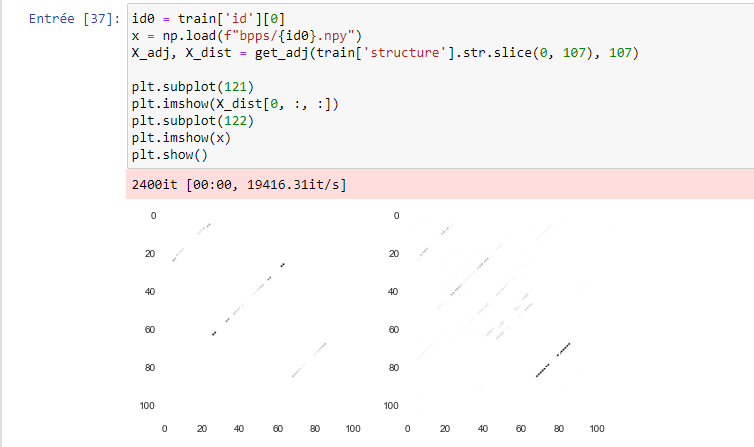